Importo tutte le librerie necessarie

In [1]:
#Queste dovrebbero essere tutte le librerie necessarie

import numpy as np
import os
import glob
import cv2 as cv2 #openCV library

import keras as ks #cnn library
#Some functionality
from keras.models import Sequential #to create a model with layer
#function for model creation
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation
from keras.callbacks import EarlyStopping #to stop training
from sklearn.model_selection import train_test_split #to split train set
from keras.utils import to_categorical #for create a categorical image

#to plot some results
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf #For cnn
import seaborn as sn


#import os
#import glob
#import cv2 as cv2
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt; 
#import PIL
#import itertools


#import keras as ks
#from sklearn.metrics import confusion_matrix, accuracy_score
#from sklearn.model_selection import train_test_split

#from keras.utils import to_categorical, np_utils

#from keras.models import Sequential
#from keras.applications import VGG16
#from keras.applications import imagenet_utils
#from keras.callbacks import ModelCheckpoint. EarlyStopping
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
#from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation
#from keras.layers import Flatten, GlobalAveragePooling2D

#import time



#from sklearn.svm import SVC

#import warnings 
#warnings.filterwarnings('ignore')

Definisco la funzione per prelevare le immagini e creare il dataset


In [2]:
def read_image_from(path, label):
    y = [] #type of image
    x = [] #image

    for idx, i in enumerate(label):
        for im in glob.glob(path + '/' + i + '/*.jpg', recursive=True):
            # color conversion to black and white images
            x.append(cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2GRAY))
            y.append(idx)

    return x, y

In [3]:
def reshape_image(x, width, height, channel):
    # Using anisotropic rescaling, resize the images to 64x64 in order to feed them to the network
    x = np.array([cv2.resize(im, (width, height), interpolation=cv2.INTER_AREA) for im in x])
    x = np.array([np.reshape(im, (width, height, channel)) for im in x]) #per rendere l'array nuovamente conitnuo

    # normalize the images
    x = x / 255

    return x

Inizio a creare le variabili di lavoro

In [4]:
#path to the directories [Adriano]
PATH_TRAIN=r'C:\Users\adria\Desktop\CVPR\Imageset\train'
PATH_TEST=r'C:\Users\adria\Desktop\CVPR\Imageset\test'

#path to the directories [Giovanni]
#PATH_TRAIN=r'C:\Users\adria\Desktop\CVPR\Imageset\train'
#PATH_TEST=r'C:\Users\adria\Desktop\CVPR\Imageset\tes'

#array of the class
labels=[os.path.basename(i) for i in glob.glob(PATH_TRAIN + '/*', recursive=True)]
num_classes = len(labels) #15
print("Classes number are: ", num_classes)
print("Class names: ", labels)
#all labels are correct

Classes number are:  15
Class names:  ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


In [5]:
X_train_raw, y_train_raw = read_image_from(PATH_TRAIN, labels) #get train dataset
X_test, y_test = read_image_from(PATH_TEST, labels) #get test dataset 
print('Image Dimensions : ',X_test[0].shape)
print('len train x: ',len(X_train_raw))
print('len test x: ',len(X_test))
print('len train y: ',len(y_train_raw))
print('len test y: ',len(y_test))

Image Dimensions :  (200, 276)
len train x:  1500
len test x:  2985
len train y:  1500
len test y:  2985


In [6]:
#test if the images has been read
cv2.imshow("Immagine iniziale", X_train_raw[0])
#without this command the imageshow crash
cv2.waitKey(0)
cv2.destroyAllWindows() 

Asintropic reduction of images

In [7]:
X_train_raw = reshape_image(X_train_raw, width = 64, height = 64, channel = 1)
X_test = reshape_image(X_test, width = 64, height = 64, channel = 1)
print("Reshaped image")

Reshaped image


In [8]:
#keras functionality 
y_train_one_hot = to_categorical(y_train_raw) #from vector to binary class matrix
y_test_one_hot = to_categorical(y_test)
print("Now y is: ", y_train_one_hot)

Now y is:  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


Create a new dataset

In [9]:
#using sklearn.model function to split training set between train 85% and validation set 15%
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_raw, y_train_one_hot, train_size=0.85, random_state=42)
print('Train set dimintion: ',len(X_train))
print('Validation set dimintion: ',len(X_validation))
print('Test set dimintion: ',len(X_test))

Train set dimintion:  1275
Validation set dimintion:  225
Test set dimintion:  2985


Model Definition and Model Training

In [10]:
#necessario randomizzare, ottimizzare, creare il modello con sequential 
#ed inserire le vaire matrici di convoluzione

#keras.initializers.RandomNormal = inizializza e genera un tensor con distribuuzione normale
#      -mean, standard deviation, seed

#keras.optimizers.SGD = Crea un gradiente discendente ottimizzato
#      -learning_rate, momento = accellerazione della discesa, 
#      -nasterov = valore per il momento, nome = nome opzionale per il gradiente
#      -**kwargss = parole chiavi per gli argomenti

#keras.Sequential() = ragruppa i layers in un modello, possiamo inserire una
#   lista di layer al proprio interno o utilizzare la funzione .add. Possiamo
#   assegnare un nome al modello
#mkeras.model.compile = dal gruppo di layer in un oggetto


#For Sequential model we need:
#-Conv2D = for convolution layer. This layer creates a convolution kernel 
#     that is convolved with the layer input to produce a tensor of output. 
#     For use it we need a resharp of images
#
#-MaxPooling2D = downsamples the input representation by taking the maximum value 
#     over the window defined by pool_size.



In [11]:
#normalizzazione e ottimizzazione del modello
norm = ks.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
stochastic_gradient = ks.optimizers.SGD(momentum=0.9, nesterov=True)

In [12]:
#creazione del modello vero e porprio
base_model = Sequential([
    Conv2D(8, 3,strides=1, padding='same',input_shape=(64,64,1)),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(16, 3,strides=1, padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(32, 3,strides=1, padding='same'),
    Activation('relu'),
    Flatten(),
    #set the initial bias values to 0
    Dense(num_classes, activation='softmax',kernel_initializer=norm, bias_initializer='zeros')
])
print("Model summary")
base_model.summary()
#recompile the model (teoricamente non credo ci sia di bisogno perché aggiungiamo
# tutti i layers direttamente sul sequential, ma nel dubbio lo faccio)
base_model.compile(loss='categorical_crossentropy', optimizer=stochastic_gradient, metrics = ['accuracy'])
print("Model summary after compiling")
base_model.summary()

Model summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16

Training and visualizzation of values


In [13]:
#keras.EarlyStopping = to stop training quando una meterica non mostra miglioramento 
es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.10)
batch_sz = 32 #number of samples for feed the network
#Train la cnn costruita precedentemente
base_history = base_model.fit(
    X_train,
    y_train,
    batch_size = batch_sz,
    epochs=100,
    validation_data=(X_validation, y_validation),
    shuffle=True,
    callbacks=[es]
)

Epoch 1/100
40/40 [==============================] - 3s 56ms/step - loss: 2.7084 - accuracy: 0.0694 - val_loss: 2.6999 - val_accuracy: 0.1200
Epoch 2/100
40/40 [==============================] - 1s 28ms/step - loss: 2.6874 - accuracy: 0.1035 - val_loss: 2.6154 - val_accuracy: 0.1733
Epoch 3/100
40/40 [==============================] - 1s 28ms/step - loss: 2.5468 - accuracy: 0.1944 - val_loss: 2.4271 - val_accuracy: 0.2044
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 2.3707 - accuracy: 0.2626 - val_loss: 2.3113 - val_accuracy: 0.2533
Epoch 5/100
40/40 [==============================] - 1s 28ms/step - loss: 2.1425 - accuracy: 0.3307 - val_loss: 2.0887 - val_accuracy: 0.3200
Epoch 6/100
40/40 [==============================] - 1s 31ms/step - loss: 1.8661 - accuracy: 0.4160 - val_loss: 2.0285 - val_accuracy: 0.3378
Epoch 7/100
40/40 [==============================] - 1s 28ms/step - loss: 1.5565 - accuracy: 0.5080 - val_loss: 1.9760 - val_accuracy: 0.3556
Epoch 

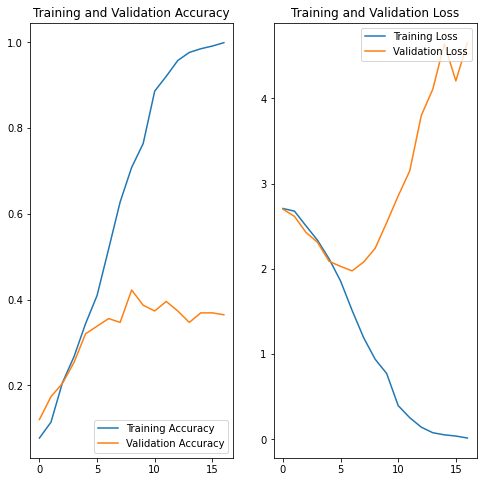

In [14]:
#add some graph use some function
acc = base_history.history['accuracy']
val_acc = base_history.history['val_accuracy']
loss = base_history.history['loss']
val_loss = base_history.history['val_loss']
ranges=range(len(acc))

#some plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(ranges, acc, label='Training Accuracy')
plt.plot(ranges, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ranges, loss, label='Training Loss')
plt.plot(ranges, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Valutazione del modello utilizzando la libreria

In [15]:
base_loss, base_accuracy = base_model.evaluate(X_test,y_test_one_hot)
print("loss: {:.2f}".format(base_loss))
print("accuracy: {:.2f}".format(base_accuracy))

94/94 [==============================] - 1s 8ms/step - loss: 4.2538 - accuracy: 0.3943
loss: 4.25
accuracy: 0.39
